In [1]:
%load_ext tensorboard
import os 
from helpers_image_classification import *
import cv2
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10000)
from load_data import *
from itertools import chain
from collections import Counter
import re
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
from PIL import ImageStat, Image

Init Plugin
Init Graph Optimizer
Init Kernel


# Extract labeled data

In [2]:
images_path = os.listdir("data/images")
images_path.sort()

In [3]:
images_path = pd.Series(images_path)
listing_ids = images_path.str.extract("(^\d*_\d*)").values

In [4]:
data = open("labels_raw.json")
labels_raw = json.load(data)

## Get an overview over the most common words

In [5]:
ids = list(labels_raw.keys())
all_labels_raw = []
for i in ids:
    all_labels_raw += labels_raw[i]
words_raw = pd.Series(all_labels_raw).str.lower().str.split()
all_words_raw = list(chain.from_iterable(list(words_raw.values)))
c = Counter(all_words_raw)
c.most_common(50)


[('image', 55910),
 ('listing', 53514),
 ('the', 5824),
 ('2', 5523),
 ('1', 5515),
 ('bedroom', 5203),
 ('room', 4962),
 ('3', 4830),
 ('4', 4273),
 ('5', 4050),
 ('and', 3992),
 ('6', 3613),
 ('with', 3573),
 ('kitchen', 3246),
 ('7', 3225),
 ('living', 3117),
 ('8', 2918),
 ('bathroom', 2865),
 ('9', 2626),
 ('10', 2510),
 ('of', 2351),
 ('to', 2222),
 ('a', 2126),
 ('11', 2122),
 ('12', 1888),
 ('in', 1792),
 ('13', 1674),
 ('area', 1658),
 ('from', 1649),
 ('14', 1500),
 ('15', 1420),
 ('double', 1366),
 ('view', 1365),
 ('bed', 1349),
 ('is', 1289),
 ('16', 1199),
 ('dining', 1199),
 ('for', 1163),
 ('-', 1120),
 ('garden', 1110),
 ('17', 1101),
 ('18', 1033),
 ('19', 957),
 ('20', 922),
 ('shower', 858),
 ('full', 809),
 ('21', 777),
 ('on', 777),
 ('front', 749),
 ('main', 728)]

Lets get rid of all digits and typical standard non-informative descpriptions

In [6]:
all_words_raw = list(filter(lambda x: x.isalpha(), all_words_raw))
all_words_raw = list(filter(lambda x: x not in ["image", "listing", "the", "a", "with", "is", "for", "in", "to", "from", "of", "and", "on", "you"], all_words_raw))

c = Counter(all_words_raw)
c.most_common(50)

[('bedroom', 5203),
 ('room', 4962),
 ('kitchen', 3246),
 ('living', 3117),
 ('bathroom', 2865),
 ('area', 1658),
 ('double', 1366),
 ('view', 1365),
 ('bed', 1349),
 ('dining', 1199),
 ('garden', 1110),
 ('shower', 858),
 ('full', 809),
 ('front', 749),
 ('main', 728),
 ('shared', 683),
 ('private', 675),
 ('walk', 659),
 ('house', 655),
 ('sitting', 650),
 ('entrance', 630),
 ('balcony', 596),
 ('large', 594),
 ('your', 588),
 ('master', 587),
 ('our', 574),
 ('ensuite', 572),
 ('dublin', 539),
 ('back', 530),
 ('single', 488),
 ('space', 484),
 ('park', 470),
 ('guest', 442),
 ('apartment', 439),
 ('tv', 407),
 ('king', 405),
 ('this', 404),
 ('at', 401),
 ('hall', 389),
 ('hallway', 367),
 ('table', 347),
 ('all', 342),
 ('size', 339),
 ('floor', 333),
 ('patio', 326),
 ('city', 325),
 ('spacious', 321),
 ('street', 320),
 ('door', 316),
 ('or', 310)]

We can use some keywords to label the data.
Therefore we construct a loop over all listings which searches for one of the words in the raw labels and loads the corresponding image, saving it with the listing id and its category.

In [7]:
# store labels_raw
l = []
# store path of image
p = []

for id in tqdm(ids):
    labels = labels_raw[id]

    for i, label in enumerate(labels):
        p.append(str(id)+"_"+str(i)+".png")
        l.append(label.lower())

label_df = pd.DataFrame({"img_path":p, "label_raw":l})

100%|██████████| 6976/6976 [00:00<00:00, 163959.90it/s]


there are some cases where we couldn't scrape the picture. Let's remove all descriptions where we don't have any picture for.

In [8]:
no_image = list(set(list(p)) - set(images_path))

In [9]:
no_image

['26128805_30.png',
 '26130497_31.png',
 '29377730_36.png',
 '29376561_37.png',
 '26131036_29.png',
 '49941172_20.png',
 '18632887_6.png',
 '14493319_1.png',
 '14330376_0.png']

In [10]:
filter = np.repeat(False, len(label_df))
for i in no_image:
    filter += label_df["img_path"] == i

In [11]:
label_df = label_df[~filter]

Make a new columns for each category that might be reasonable
- bedroom (including bed)
- kitchen
- living_room
- dining
- bathroom 
- hallway 
- balcony 

- others (including street, city, dublin, dog, cat, people, stop, bus, gym, activities)


Having 8 categories

To make sure we reduce the errors of image labels "views on something from somewhere", like "view on Dublin from bedroom" should be removed from our raw labels

In [12]:
test = label_df["label_raw"]

In [13]:
f = [bool(re.search(r"(view|look) (on|from|to|of) [a-z]* [a-z]* [a-z]*", string)) for string in list(test.values)]
print(np.array(f).sum())
test[np.array(f)]

491


109      view from my secret garden of killiney bay and...
111            view of dalkey from hill of same name . . .
117      a close-up view of the back garden. now can yo...
118      a view of the back garden. can you see the squ...
257             view from outer court into inner courtyard
323                view from hall through to living space 
411      view from sleeping loft - any one for 'blancma...
435      exterior view from corner of park showing typi...
483      view of the house and its neighbour, built as ...
485                       view of house from mountjoy park
661      balcony view: james joyce bridge on the west, ...
665      view from living room - city hall to the left,...
788           view from decking area on the ground floor. 
789      view from the beach of the apartment on first ...
841       view of sitting room including fireplace and tv!
851            closer view of dining room table and chairs
852      sideview of kitchen with fridge/freezer on far.

There are more than 400 of those cases. Let's remove these words

In [14]:
label_raw_new = [re.sub(r"((view|look) (on|from|to|of) [a-z]*|(view|look) (on|from|to|of) [a-z]* [a-z]*|(view|look) (on|from|to|of) [a-z]* [a-z]* [a-z]*)", "", string) for string in list(label_df["label_raw"].values)]
label_df["label_raw"] = np.array(label_raw_new)

label_raw_new = [re.sub(r"[0-9]*", "", string) for string in list(label_df["label_raw"].values)]
label_df["label_raw"] = np.array(label_raw_new)

label_raw_new = [re.sub(r"(listing|image)", "", string) for string in list(label_df["label_raw"].values)]
label_df["label_raw"] = np.array(label_raw_new)

label_raw_new = [re.sub(r"window (facing|to) [a-z]* [a-z]*", "", string) for string in list(label_df["label_raw"].values)]
label_df["label_raw"] = np.array(label_raw_new)

In [15]:
# separate id and image number
df = label_df["img_path"].str.split("_", expand = True)
df.columns = ["listing_id", "img_no"]
label_df["id"] = df["listing_id"]

df = df["img_no"].str.split(".", expand = True)
df.columns = ["img_no", "png"]
label_df["img_no"] = df["img_no"]

In [16]:
bedroom = [bool(re.search(r"(bedroom|(^| )bed( |$))", string)) for string in list(label_df["label_raw"].values)]
label_df[np.array(bedroom)]
label_df["bedroom"] = np.array(bedroom).astype(int)

kitchen = [bool(re.search(r"kitchen", string)) for string in list(label_df["label_raw"].values)]
label_df[np.array(kitchen)]
label_df["kitchen"] = np.array(kitchen).astype(int)

living = [bool(re.search(r"(living room|living area|living space)", string)) for string in list(label_df["label_raw"].values)]
label_df[np.array(living)]
label_df["living"] = np.array(living).astype(int)

dining = [bool(re.search(r"(dining room|dining area|dining space|dining table)", string)) for string in list(label_df["label_raw"].values)]
label_df[np.array(dining)]
label_df["dining"] = np.array(dining).astype(int)

bathroom = [bool(re.search(r"(bathroom|(^| )bath( |$)|(^| )shower( |$))", string)) for string in list(label_df["label_raw"].values)]
label_df[np.array(bathroom)]
label_df["bathroom"] = np.array(bathroom).astype(int)

hallway = [bool(re.search(r"(hallway|(^| )hall( |$))", string)) for string in list(label_df["label_raw"].values)]
label_df[np.array(hallway)]
label_df["hallway"] = np.array(hallway).astype(int)

balcony = [bool(re.search(r"(^| )balcony", string)) for string in list(label_df["label_raw"].values)]
label_df[np.array(balcony)]
label_df["balcony"] = np.array(balcony).astype(int)

others = [bool(re.search(r"((^| )exterior( |$)|(^| )house( |$)|(^| )garden|(^| )park|street( |$)|city( |$)|dublin( |$)|(^| )dog( |$)|(^| )cat( |$)|(^| )attraction( |$))", string)) for string in list(label_df["label_raw"].values)]
label_df[np.array(others)]
label_df["others"] = np.array(others).astype(int)

In [17]:
#show_category("balcony", df = label_df)

Let's drop every picture which has more than 1 label

In [18]:
label_cols = ["bedroom", "kitchen", "living", "dining", "bathroom", "others","hallway","balcony"]
(label_df.filter(label_cols).sum(axis = 1) > 1).sum()

1535

In [19]:
filter = (label_df.filter(label_cols).sum(axis = 1) > 1)
train_df = label_df[~filter]

In [20]:
#show_category("others", df = train_df, n = 20)

How many image of each category do we have?

In [21]:
label_df.filter(label_cols).sum(axis = 0)

bedroom     6333
kitchen     3655
living      2997
dining      1122
bathroom    3641
others      3764
hallway      758
balcony      625
dtype: int64

So how many images with exactly 1 category do we have?

In [22]:
(label_df.filter(label_cols).sum(axis = 1) == 1).sum()

19712

# Use only data with 1 label

In [23]:
filter = label_df.filter(label_cols).sum(axis = 1) == 1

Create a dataframe that we will use to train the model and one to perform predictions. 
Let's save this for later.

In [24]:
train_df = label_df[filter]
unlabeled_df = label_df[~filter]

train_df.head()

,img_path,label_raw,id,img_no,bedroom,kitchen,living,dining,bathroom,hallway,balcony,others
1,44077_1.png,our living room,44077,1,0,0,1,0,0,0,0,0
3,44077_3.png,cosy & comfortable double bedroom with firepl...,44077,3,1,0,0,0,0,0,0,0
7,44077_7.png,hall,44077,7,0,0,0,0,0,1,0,0
8,44077_8.png,hall,44077,8,0,0,0,0,0,1,0,0
13,44077_13.png,luas tram mins walk from our house mins to t...,44077,13,0,0,0,0,0,0,0,1


In [25]:
train_df.set_index('img_path',inplace=True, drop = False)

# turn dummies into string for category
train_df = train_df[train_df[label_cols]==1].stack().reset_index().drop(0,1)
train_df.columns = ["img_path","label"]

# separate id and image number
df = train_df["img_path"].str.split("_", expand = True)
df.columns = ["listing_id", "img_no"]
train_df["id"] = df["listing_id"]

df = df["img_no"].str.split(".", expand = True)
df.columns = ["img_no", "png"]
train_df["img_no"] = df["img_no"]

# store label in one column
le = preprocessing.LabelEncoder()
le.fit(train_df["label"])
train_df['categorical_label'] = le.transform(train_df["label"])

# Model Training

## Create tfrecord data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(train_df["img_path"].values, train_df["categorical_label"].values, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.1, random_state=1) 

In [31]:
write_features(X_train, y_train, filename= "data/tfrecord_labeled_small/train")
write_features(X_test, y_test, filename= "data/tfrecord_labeled_small/test")
write_features(X_val, y_val, filename= "data/tfrecord_labeled_small/val")

  0%|          | 0/15966 [00:00<?, ?it/s]2022-01-09 20:00:22.652129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-09 20:00:22.657772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
  0%|          | 8/15966 [00:00<07:20, 36.20it/s]

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



100%|██████████| 1774/1774 [00:26<00:00, 66.28it/s]


1774

In [27]:
train_dataset = make_dataset("data/tfrecord_labeled_small/train.tfr", batch_size = 32, training = True)
test_dataset = make_dataset("data/tfrecord_labeled_small/test.tfr", batch_size = 32)
val_dataset = make_dataset("data/tfrecord_labeled_small/val.tfr", batch_size = 32)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-01-11 08:50:02.580248: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-11 08:50:02.580516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:
def train_model(traindata, valdata, lr, epochs, callbacks = None):
   
    # Define Input
    inputs = tf.keras.layers.Input(shape = (256, 256, 3), name = "input_1")

    # Load ResNet with pretrained Imagenet weights
    resnet = tf.keras.applications.resnet.ResNet101(include_top=False, weights='imagenet', input_tensor=inputs, pooling="avg")

    # freeze the weights
    resnet.trainable = False

    # Layer 1 - Flatten
    outputs = tf.keras.layers.Flatten()(resnet.output)
    # Layer 2 - Dense ReLu
    outputs = tf.keras.layers.Dense(1000, activation = "relu")(outputs)
    # Layer 3 - Dense ReLu 
    outputs = tf.keras.layers.Dense(500, activation = "relu")(outputs)
    # Layer 4 - Dense Output 
    outputs = tf.keras.layers.Dense(8)(outputs)

    # Combine pretrained and output model
    model_resnet = tf.keras.Model(inputs, outputs)

    model_resnet.compile(optimizer=tf.keras.optimizers.Adam(lr = lr),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    model_resnet.fit(traindata, validation_data = valdata, epochs = epochs, callbacks = callbacks)
    return model_resnet

In [47]:
lrs = [0.0001, 0.00001, 0.000001]
for lr in lrs:
    logdir = "logs/labeling_small/resnet_lr_nofilter"+str(lr)
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    callbacks = [tensorboard_callback]   
    model = train_model(train_dataset, val_dataset, epochs = 15, lr = lr, callbacks = callbacks)


2022-01-10 02:05:48.743541: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-10 02:05:48.744035: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-01-10 02:05:48.747636: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
/Users/dmnk/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/dmnk/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/15


2022-01-10 02:06:02.872400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


      1/Unknown - 17s 17s/step - loss: 2.1146 - accuracy: 0.2188

2022-01-10 02:06:10.183994: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-10 02:06:10.184022: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


      2/Unknown - 18s 2s/step - loss: 1.9555 - accuracy: 0.2969 

2022-01-10 02:06:12.270717: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-10 02:06:12.282039: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-01-10 02:06:12.351809: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/labeling_small/resnet_lr_nofilter0.0001/train/plugins/profile/2022_01_10_02_06_12
2022-01-10 02:06:12.366874: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/labeling_small/resnet_lr_nofilter0.0001/train/plugins/profile/2022_01_10_02_06_12/Air-von-Dominik.fritz.box.trace.json.gz
2022-01-10 02:06:12.438077: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/labeling_small/resnet_lr_nofilter0.0001/train/plugins/profile/2022_01_10_02_06_12
2022-01-10 02:06:12.438351: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_

    499/Unknown - 614s 1s/step - loss: 0.6755 - accuracy: 0.7987

2022-01-10 02:16:10.055014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


499/499 [==============================] - 679s 1s/step - loss: 0.6755 - accuracy: 0.7987 - val_loss: 0.6541 - val_accuracy: 0.8005
Epoch 2/15
499/499 [==============================] - 661s 1s/step - loss: 0.5091 - accuracy: 0.8442 - val_loss: 0.5986 - val_accuracy: 0.8191
Epoch 3/15
499/499 [==============================] - 705s 1s/step - loss: 0.4242 - accuracy: 0.8713 - val_loss: 0.5766 - val_accuracy: 0.8371
Epoch 4/15
499/499 [==============================] - 697s 1s/step - loss: 0.3542 - accuracy: 0.8936 - val_loss: 0.5639 - val_accuracy: 0.8298
Epoch 5/15
499/499 [==============================] - 676s 1s/step - loss: 0.2827 - accuracy: 0.9152 - val_loss: 0.5654 - val_accuracy: 0.8399
Epoch 6/15
499/499 [==============================] - 681s 1s/step - loss: 0.2223 - accuracy: 0.9349 - val_loss: 0.6297 - val_accuracy: 0.8320
Epoch 7/15
499/499 [==============================] - 675s 1s/step - loss: 0.1555 - accuracy: 0.9568 - val_loss: 0.6177 - val_accuracy: 0.8393
Epoch 8/15

2022-01-10 04:55:26.637012: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-10 04:55:26.641222: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-01-10 04:55:26.651154: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/15


2022-01-10 04:56:01.206270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


      1/Unknown - 19s 19s/step - loss: 2.0838 - accuracy: 0.1250

2022-01-10 04:56:18.600664: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-10 04:56:18.600694: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


      2/Unknown - 24s 5s/step - loss: 2.0955 - accuracy: 0.0938 

2022-01-10 04:56:24.590984: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-10 04:56:24.787045: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-01-10 04:56:24.971874: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/labeling_small/resnet_lr_nofilter1e-05/train/plugins/profile/2022_01_10_04_56_24
2022-01-10 04:56:25.017388: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/labeling_small/resnet_lr_nofilter1e-05/train/plugins/profile/2022_01_10_04_56_24/Air-von-Dominik.fritz.box.trace.json.gz
2022-01-10 04:56:25.183757: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/labeling_small/resnet_lr_nofilter1e-05/train/plugins/profile/2022_01_10_04_56_24
2022-01-10 04:56:25.187640: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_pro

    499/Unknown - 629s 1s/step - loss: 0.9436 - accuracy: 0.7260

2022-01-10 05:06:29.789671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


499/499 [==============================] - 696s 1s/step - loss: 0.9436 - accuracy: 0.7260 - val_loss: 0.7294 - val_accuracy: 0.7768
Epoch 2/15
499/499 [==============================] - 666s 1s/step - loss: 0.6387 - accuracy: 0.8103 - val_loss: 0.6627 - val_accuracy: 0.7999
Epoch 3/15
499/499 [==============================] - 668s 1s/step - loss: 0.5808 - accuracy: 0.8271 - val_loss: 0.6320 - val_accuracy: 0.8117
Epoch 4/15
499/499 [==============================] - 671s 1s/step - loss: 0.5447 - accuracy: 0.8398 - val_loss: 0.6193 - val_accuracy: 0.8196
Epoch 5/15
499/499 [==============================] - 674s 1s/step - loss: 0.5190 - accuracy: 0.8483 - val_loss: 0.6063 - val_accuracy: 0.8230
Epoch 6/15
499/499 [==============================] - 671s 1s/step - loss: 0.4947 - accuracy: 0.8557 - val_loss: 0.5972 - val_accuracy: 0.8247
Epoch 7/15
499/499 [==============================] - 702s 1s/step - loss: 0.4741 - accuracy: 0.8620 - val_loss: 0.5842 - val_accuracy: 0.8320
Epoch 8/15

A learning rate of 0.000001 performs reasonably well. 
Let's implement early stopping and learning rate scheduling

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
logdir = "logs/labeling_small/final_model"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
callbacks = [tensorboard_callback, early_stopping, reduce_lr]

final_model = train_model(train_dataset, val_dataset, epochs = 50, lr = 0.00001, callbacks = callbacks)

2022-01-09 20:05:52.363320: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-09 20:05:52.363334: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-01-09 20:05:52.364349: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
/Users/dmnk/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/Users/dmnk/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2022-01-09 20:05:54.635494: I tensorflow/compiler/mlir/mlir_graph_optimization_p

Epoch 1/50


2022-01-09 20:05:57.861715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


      1/Unknown - 7s 7s/step - loss: 2.1268 - accuracy: 0.2500

2022-01-09 20:06:02.371836: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-09 20:06:02.371861: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


      2/Unknown - 9s 1s/step - loss: 2.0707 - accuracy: 0.2656

2022-01-09 20:06:03.499887: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-09 20:06:03.508498: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-01-09 20:06:03.520159: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/labeling_small/final_model/train/plugins/profile/2022_01_09_20_06_03
2022-01-09 20:06:03.522706: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/labeling_small/final_model/train/plugins/profile/2022_01_09_20_06_03/Air-von-Dominik.fritz.box.trace.json.gz
2022-01-09 20:06:03.533542: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/labeling_small/final_model/train/plugins/profile/2022_01_09_20_06_03
2022-01-09 20:06:03.533750: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/labeling_small/

    499/Unknown - 568s 1s/step - loss: 0.9474 - accuracy: 0.7210

2022-01-09 20:15:24.153929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


499/499 [==============================] - 635s 1s/step - loss: 0.9474 - accuracy: 0.7210 - val_loss: 0.7472 - val_accuracy: 0.7745
Epoch 2/50
499/499 [==============================] - 722s 1s/step - loss: 0.6378 - accuracy: 0.8100 - val_loss: 0.6694 - val_accuracy: 0.8027
Epoch 3/50
499/499 [==============================] - 745s 1s/step - loss: 0.5785 - accuracy: 0.8286 - val_loss: 0.6415 - val_accuracy: 0.8089
Epoch 4/50
499/499 [==============================] - 778s 2s/step - loss: 0.5437 - accuracy: 0.8410 - val_loss: 0.6272 - val_accuracy: 0.8157
Epoch 5/50
499/499 [==============================] - 727s 1s/step - loss: 0.5162 - accuracy: 0.8493 - val_loss: 0.6128 - val_accuracy: 0.8219
Epoch 6/50
499/499 [==============================] - 732s 1s/step - loss: 0.4922 - accuracy: 0.8568 - val_loss: 0.6056 - val_accuracy: 0.8207
Epoch 7/50
499/499 [==============================] - 817s 2s/step - loss: 0.4720 - accuracy: 0.8622 - val_loss: 0.5989 - val_accuracy: 0.8207
Epoch 8/50

In [35]:
y_pred = tf.keras.activations.sigmoid(final_model.predict(test_dataset))
y_pred_max = tf.argmax(y_pred, axis = 1).numpy()

2022-01-10 01:07:34.709786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [38]:
label_book = train_df[["label","categorical_label"]].drop_duplicates().sort_values(by="label")
label_book

,label,categorical_label
99,balcony,0
21,bathroom,1
1,bedroom,2
80,dining,3
2,hallway,4
19,kitchen,5
0,living,6
4,others,7


In [37]:
y_test = np.concatenate([y for x, y in test_dataset], axis=0)
X_test = np.concatenate([x["input_1"] for x, y in test_dataset], axis=0)

show the first 30 predicitions with images

1
1
tf.Tensor(
[0.05924397 0.99623376 0.66964126 0.09177992 0.11920506 0.7620897
 0.237106   0.40016004], shape=(8,), dtype=float32)


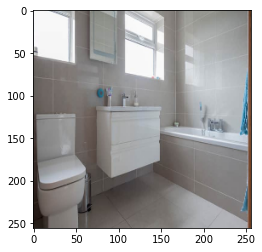

1
1
tf.Tensor(
[0.94098073 0.97441363 0.953003   0.00827902 0.06983124 0.1311981
 0.22101983 0.511398  ], shape=(8,), dtype=float32)


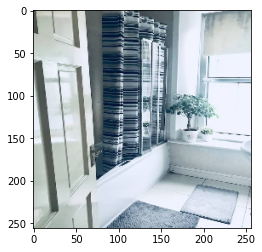

2
2
tf.Tensor(
[0.38015735 0.7613933  0.9979346  0.01780996 0.10811304 0.02299328
 0.25622818 0.6836276 ], shape=(8,), dtype=float32)


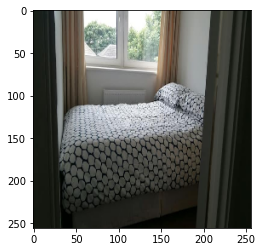

2
2
tf.Tensor(
[0.10989475 0.02551012 0.9508587  0.9325293  0.0529627  0.64312017
 0.90128267 0.75237024], shape=(8,), dtype=float32)


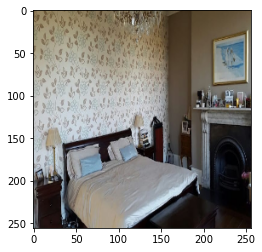

5
5
tf.Tensor(
[0.44176084 0.01373782 0.08086631 0.8677686  0.4013673  0.9748131
 0.8061858  0.92643523], shape=(8,), dtype=float32)


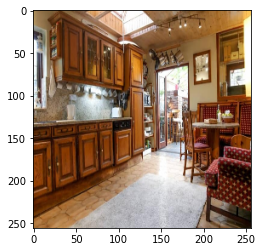

2
2
tf.Tensor(
[0.3331741  0.30345187 0.9634079  0.32556996 0.01852157 0.3784688
 0.89518535 0.76933783], shape=(8,), dtype=float32)


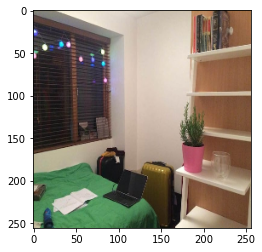

2
2
tf.Tensor(
[0.02930237 0.08056436 0.8655229  0.37945643 0.6815761  0.8293743
 0.5979369  0.4515985 ], shape=(8,), dtype=float32)


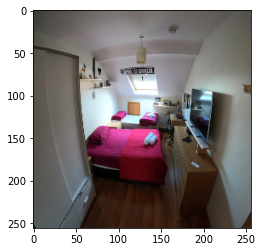

2
2
tf.Tensor(
[0.133653   0.44679093 0.9992903  0.0885366  0.0741915  0.05907785
 0.3182419  0.72752553], shape=(8,), dtype=float32)


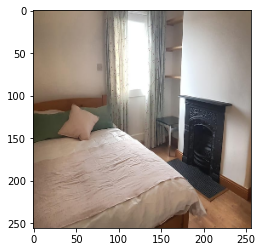

6
6
tf.Tensor(
[0.34691232 0.05692323 0.88468    0.3716335  0.2927266  0.8672302
 0.9563209  0.7443674 ], shape=(8,), dtype=float32)


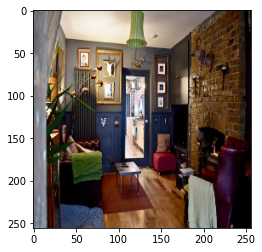

5
5
tf.Tensor(
[0.09409856 0.22052382 0.16879407 0.4941813  0.6846323  0.9956785
 0.5522692  0.47724608], shape=(8,), dtype=float32)


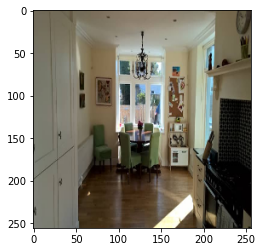

3
3
tf.Tensor(
[0.1506449  0.04450074 0.66090846 0.9667854  0.32562178 0.7432612
 0.7223619  0.1847149 ], shape=(8,), dtype=float32)


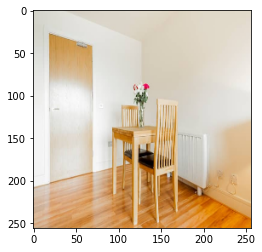

2
2
tf.Tensor(
[0.2818539  0.6478821  0.9970227  0.0183121  0.0928323  0.14578782
 0.41635108 0.8313603 ], shape=(8,), dtype=float32)


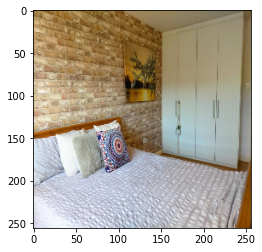

6
6
tf.Tensor(
[0.04820066 0.2871259  0.8967971  0.55106795 0.02743603 0.40314132
 0.9702535  0.5795099 ], shape=(8,), dtype=float32)


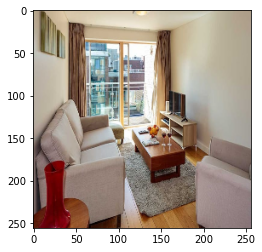

1
1
tf.Tensor(
[0.03577437 0.9997483  0.75921994 0.04419177 0.10325193 0.54682136
 0.13772    0.1632435 ], shape=(8,), dtype=float32)


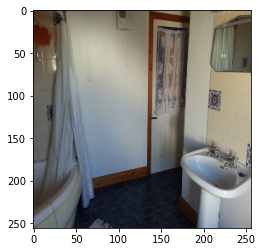

1
1
tf.Tensor(
[0.03861498 0.9993821  0.9274963  0.0416981  0.40191966 0.26827988
 0.21786185 0.22685736], shape=(8,), dtype=float32)


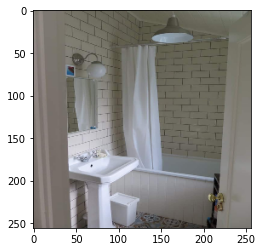

5
5
tf.Tensor(
[0.06328191 0.07988256 0.2497442  0.29340813 0.12348612 0.9999378
 0.4279489  0.98045874], shape=(8,), dtype=float32)


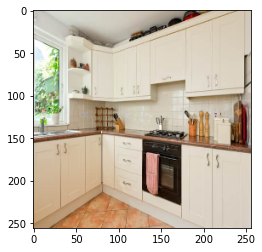

1
1
tf.Tensor(
[0.07259947 0.99820757 0.7358503  0.08877596 0.0522162  0.40100196
 0.12922299 0.28265366], shape=(8,), dtype=float32)


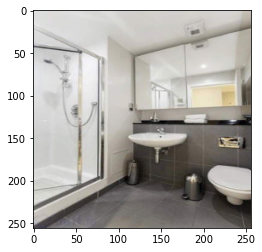

1
1
tf.Tensor(
[0.2513311  0.9985967  0.923853   0.05782225 0.12778836 0.2590625
 0.16231917 0.46669775], shape=(8,), dtype=float32)


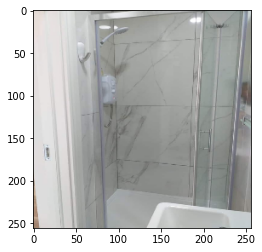

5
5
tf.Tensor(
[0.02649322 0.06265029 0.03453597 0.87807715 0.7506904  0.980015
 0.82247084 0.538651  ], shape=(8,), dtype=float32)


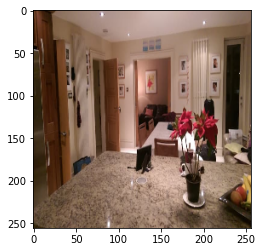

6
6
tf.Tensor(
[0.05383331 0.00796336 0.60060793 0.6463369  0.05827682 0.58802855
 0.9988257  0.73589164], shape=(8,), dtype=float32)


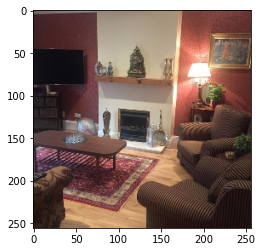

1
1
tf.Tensor(
[0.05952378 0.9943124  0.8878576  0.04007749 0.6862522  0.4711598
 0.08526717 0.26861992], shape=(8,), dtype=float32)


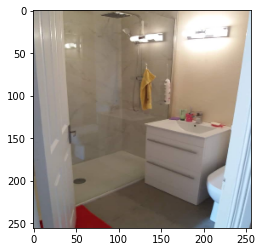

6
6
tf.Tensor(
[0.11591125 0.06392494 0.7287397  0.7773989  0.09395593 0.6578473
 0.99425715 0.54412746], shape=(8,), dtype=float32)


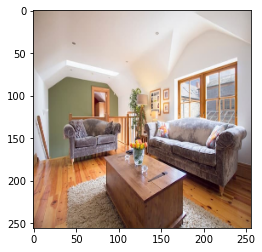

2
2
tf.Tensor(
[0.1231895  0.37237567 0.99957114 0.05442742 0.17211673 0.19495577
 0.17526087 0.88728297], shape=(8,), dtype=float32)


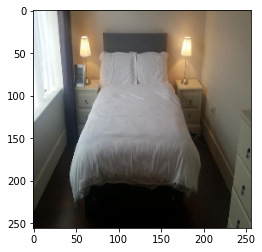

6
6
tf.Tensor(
[0.04188398 0.004633   0.6756926  0.9140161  0.7660659  0.85156286
 0.97949255 0.5941706 ], shape=(8,), dtype=float32)


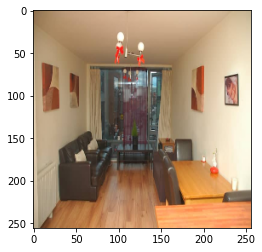

1
1
tf.Tensor(
[0.0509413  0.99969184 0.97192085 0.1343017  0.03691288 0.08555653
 0.05478913 0.25809994], shape=(8,), dtype=float32)


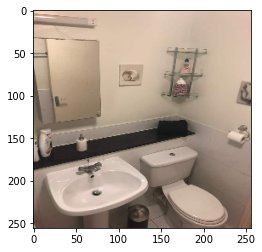

6
6
tf.Tensor(
[0.07015659 0.08373044 0.82686335 0.7572551  0.09151535 0.34391603
 0.9955941  0.59068346], shape=(8,), dtype=float32)


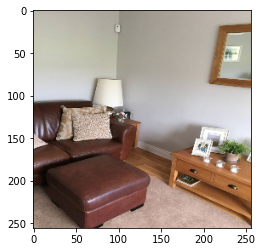

1
1
tf.Tensor(
[0.10655606 0.9866854  0.5655551  0.3387288  0.41132978 0.9523877
 0.35937756 0.05829631], shape=(8,), dtype=float32)


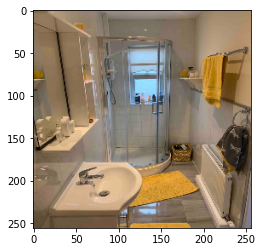

2
2
tf.Tensor(
[0.04140513 0.8923807  0.99600935 0.0668608  0.25591785 0.53350735
 0.09836476 0.39413297], shape=(8,), dtype=float32)


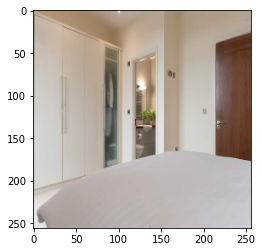

7
7
tf.Tensor(
[0.8004406  0.28250435 0.94241476 0.20689991 0.32241258 0.02413708
 0.35586634 0.99953425], shape=(8,), dtype=float32)


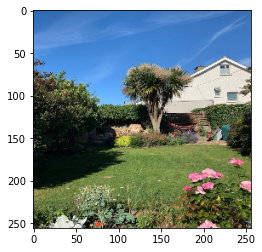

1
1
tf.Tensor(
[0.0274175  0.99762994 0.9014634  0.04830892 0.35132    0.1797635
 0.1756356  0.09910104], shape=(8,), dtype=float32)


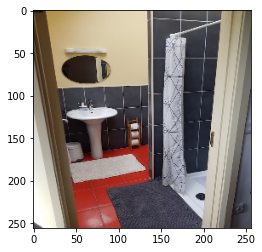

In [38]:
c = 0
for x,test, pred_class, pred in zip(X_test, y_test, y_pred_max, y_pred):
    print(test)
    print(pred_class)
    print(pred)
    plt.imshow(x)
    plt.show()
    c += 1
    if c == 30:
        break

In [39]:
path_final_model = 'img_models/classification/final_model'
final_model.save(path_final_model)

2022-01-10 01:09:09.319416: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/Users/dmnk/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: img_models/classification/final_model/assets


# Model Prediction

In [28]:
path_final_model = 'img_models/classification/final_model'
final_model = tf.keras.models.load_model(path_final_model)

Let's pick up the unlabeled pictures and predict their label with the model that is trained on all labeled data

In [29]:
unlabeled_df

,img_path,label_raw,id,img_no,bedroom,kitchen,living,dining,bathroom,hallway,balcony,others
0,44077_0.png,this is our conservatory kitchen looking out t...,44077,0,0,1,0,0,0,0,0,1
2,44077_2.png,twin bedroom with french doors leading to the ...,44077,2,1,0,0,0,0,0,0,1
4,44077_4.png,,44077,4,0,0,0,0,0,0,0,0
5,44077_5.png,,44077,5,0,0,0,0,0,0,0,0
6,44077_6.png,,44077,6,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
86436,53152026_25.png,,53152026,25,0,0,0,0,0,0,0,0
86437,53152026_26.png,,53152026,26,0,0,0,0,0,0,0,0
86438,53152026_27.png,,53152026,27,0,0,0,0,0,0,0,0
86439,53160612_0.png,our building,53160612,0,0,0,0,0,0,0,0,0


In [30]:
# we only need the img_path, id, and img_no
unlabeled_df = unlabeled_df[["img_path","id","img_no"]]
unlabeled_df

,img_path,id,img_no
0,44077_0.png,44077,0
2,44077_2.png,44077,2
4,44077_4.png,44077,4
5,44077_5.png,44077,5
6,44077_6.png,44077,6
...,...,...,...
86436,53152026_25.png,53152026,25
86437,53152026_26.png,53152026,26
86438,53152026_27.png,53152026,27
86439,53160612_0.png,53160612,0


We have to write tfrecord files again

In [42]:
write_features(unlabeled_df["img_path"], filename= "data/tfrecord_unlabeled/all", prediction = True)

100%|██████████| 66724/66724 [18:38<00:00, 59.66it/s] 


66724

In [31]:
pred_dataset = make_dataset("data/tfrecord_unlabeled/all.tfr", batch_size = 16, prediction = True)

In [32]:
pred = final_model.predict(pred_dataset, verbose = 1)

2022-01-10 07:52:37.561064: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-10 07:52:37.573614: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-10 07:52:38.448183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4171/4171 [==============================] - 2582s 619ms/step


In [33]:
pred = tf.keras.activations.sigmoid(pred)
pred_label = tf.argmax(pred, axis = 1).numpy()
pred_label 

array([5, 2, 2, ..., 7, 7, 0])

In [34]:
unlabeled_df["label"] = pred_label

/var/folders/97/j215pw6x7sq158bvx1ktlhf80000gn/T/ipykernel_75440/4089366081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_df["label"] = pred_label


In [ ]:
unlabeled_df.head()

,img_path,id,img_no,label
2,44077_2.png,44077,2,6
4,44077_4.png,44077,4,2
5,44077_5.png,44077,5,3
6,44077_6.png,44077,6,2
9,44077_9.png,44077,9,2


merge training data

In [35]:
train_df2 = train_df[["img_path","id","img_no", "categorical_label"]]
train_df2.columns = ["img_path","id","img_no", "label"]

In [36]:
final_df = pd.concat([unlabeled_df, train_df2])

In [39]:
final_df["catg_label"] = final_df["label"].replace(list(label_book["categorical_label"]), list(label_book["label"]))

In [40]:
final_df = pd.get_dummies(final_df, columns = ["catg_label"], prefix = "no_img")

In [41]:
df_labels = final_df.groupby("id").sum()

In [42]:
df_labels.reset_index(level=0, inplace=True)
df_labels = df_labels.drop("label", axis = 1)

In [43]:
df_labels.head()

,id,no_img_balcony,no_img_bathroom,no_img_bedroom,no_img_dining,no_img_hallway,no_img_kitchen,no_img_living,no_img_others
0,10006474,0,1,1,0,0,2,2,0
1,10007446,0,1,2,1,0,1,0,1
2,10027351,0,2,2,1,1,1,0,1
3,10048879,0,1,2,0,0,0,1,1
4,10069364,0,1,1,1,0,2,1,3


# Create new variables number of images and brightness

In [44]:
df_img = pd.DataFrame({"count": Counter(final_df["id"])})

In [45]:
def brightness(id, folder = "data/images/"):
   filter = final_df["id"] == id
   id_dir = final_df["img_path"][filter]
   bright = 0
   for id_img in id_dir:
      im = Image.open(folder+id_img).convert('L')
      bright += ImageStat.Stat(im).mean[0]
   return bright/len(id_dir)

In [46]:
df_img.reset_index(level=0, inplace=True)
df_img.columns = ["id", "count"]

In [47]:
brightness_list = []
for i in df_img["id"]:
    brightness_list.append(brightness(i))

In [48]:
df_img["brightness"] = brightness_list

In [54]:
df_img_info = pd.merge(df_img, df_labels, on = "id")

In [55]:
df_img_info.to_csv("data/img_info.csv")